# Single-group Segregation Indices

In [1]:
%load_ext watermark
%watermark -a 'eli knaap' -v -d -u -p segregation,geopandas,libpysal,pandana

Author: eli knaap

Last updated: 2021-06-06

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.23.1

segregation: 2.0.0
geopandas  : 0.9.0
libpysal   : 4.4.0
pandana    : not installed



Single-group indices are calculated using the `singlegroup` module

### Data Prep

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.examples import load_example

In [3]:
# read in sacramento data from libpysal and reproject into an appropriate CRS
sacramento = gpd.read_file(load_example("Sacramento1").get_path("sacramentot2.shp"))
sacramento = sacramento.to_crs(sacramento.estimate_utm_crs())

In [4]:
sacramento.head()

,FIPS,MSA,TOT_POP,POP_16,POP_65,WHITE,BLACK,ASIAN,HISP,MULTI_RA,...,EMP_FEM,OCC_MAN,OCC_OFF1,OCC_INFO,HH_INC,POV_POP,POV_TOT,HSG_VAL,POLYID,geometry
0,06061022001,Sacramento,5501,1077,518,4961,29,82,336,31,...,1187,117,663.0,42,52941,5461,470,225900,1,"POLYGON ((740409.853 4338451.728, 740199.864 4..."
1,06061020106,Sacramento,2072,396,109,1603,0,28,391,41,...,522,38,229.0,19,51958,2052,160,249300,2,"POLYGON ((753400.378 4347151.080, 753395.816 4..."
2,06061020107,Sacramento,3633,911,126,1624,9,0,1918,41,...,698,86,197.0,0,32992,3604,668,175900,3,"POLYGON ((758318.262 4352123.456, 758319.774 4..."
3,06061020105,Sacramento,1683,281,154,1564,0,55,60,4,...,519,5,256.0,6,54556,1683,116,302300,4,"POLYGON ((750839.595 4342678.807, 750805.840 4..."
4,06061020200,Sacramento,5794,1278,830,5185,17,13,251,229,...,1260,155,506.0,59,50815,5771,342,167300,5,"POLYGON ((670062.020 4311030.409, 670133.819 4..."


<AxesSubplot:>

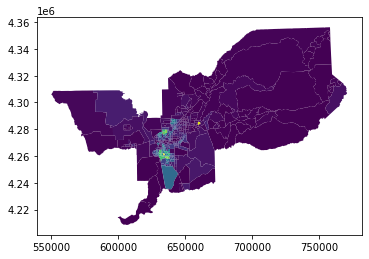

In [5]:
sacramento.plot('BLACK')

## Aspatial Segregation Indices

To compute an aspatial segregation index, pass a dataframe, a group population variable, and total population variable to the index's class

In [6]:
from segregation.singlegroup import Dissim

In [7]:
dissim = Dissim(sacramento, group_pop_var='BLACK', 
                total_pop_var='TOT_POP')

The `statistic` attribute holds the value of the segregation index, and the `data` attribute holds the data used to calculate the index

In [8]:
dissim.statistic

0.4883394024705785

In [9]:
dissim.data.head()

,BLACK,TOT_POP,geometry
0,29,5501,"POLYGON ((740409.853 4338451.728, 740199.864 4..."
1,0,2072,"POLYGON ((753400.378 4347151.080, 753395.816 4..."
2,9,3633,"POLYGON ((758318.262 4352123.456, 758319.774 4..."
3,0,1683,"POLYGON ((750839.595 4342678.807, 750805.840 4..."
4,17,5794,"POLYGON ((670062.020 4311030.409, 670133.819 4..."


### Depreciation for 2.0

In [10]:
from segregation.aspatial import Dissim 

In [11]:
res = Dissim(sacramento, group_pop_var='BLACK', 
                total_pop_var='TOT_POP')

<ipython-input-11-33d3b5bf446c>:1: DeprecatedWarning: Dissim is deprecated as of 2.0 and will be removed in 2.2. singlegroup.Dissim or multigroup.MultiDissim
  res = Dissim(sacramento, group_pop_var='BLACK',


In [12]:
res.statistic == dissim.statistic

True

## Spatial Segregation Indices

For calculating spatial segregation indices, the package implements two classes of indices: spatially-explicit and spatially-implicit. 

Spatially-explicit indices are those for which space was a formal consideration in the index's original formulation, whereas spatially-implicit indices are developed using the logic of [Reardon and O'Sulivan](http://doi.wiley.com/10.1111/j.0081-1750.2004.00150.x). 

For the latter,(otherwise called *generalized* spatial segregation indices) the package can incorporate spatial relationships represented by either a [`libpysal.W`](https://pysal.org/libpysal/api.html) weights object or a [`pandana.Network`](http://udst.github.io/pandana/network.html) network object, which means generalized spatial segregation indices can be computed according to many different spatial relationships which could include contiguity, distance, or network connectivity. This flexibility is particularly useful for specifying appropriate "neighborhood" definitions for different types of input data (which could be, e.g. housing units, census tracts, or counties)

For spatially-explicit indices, they can be called like any other, though some may have additional arguments:

In [13]:
from segregation.singlegroup import AbsoluteCentralization, Gini

In [14]:
cent = AbsoluteCentralization(sacramento, group_pop_var='BLACK', 
                              total_pop_var='TOT_POP')

In [15]:
cent.statistic

0.8491771822066525

### Euclidian distance based measures

For generalized spatial indices, a `distance` parameter can be passed to the index of choice. Under the hood, the input data will be passed through a kernel function with the distance parameter as the kernel bandwidth.

(note in this case because the CRS of the sacramento dataframe is UTM, the units are in meters)

In [16]:
# aspatial gini index
aspatial_gini = Gini(sacramento, group_pop_var='BLACK', 
                     total_pop_var='TOT_POP')

In [17]:
# generalized spatial gini index
gen_spatialgini = Gini(sacramento, group_pop_var='BLACK', 
                       total_pop_var='TOT_POP', distance=2000)

In [18]:
gen_spatialgini.statistic

0.5368102768280613

In [19]:
aspatial_gini.statistic

0.6361755332635235

Examining the `data` attribute of the fitted index shows how the input data are transformed

<AxesSubplot:>

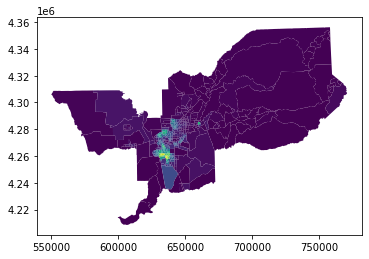

In [20]:
# kernelized data
gen_spatialgini.data.plot('BLACK')

<AxesSubplot:>

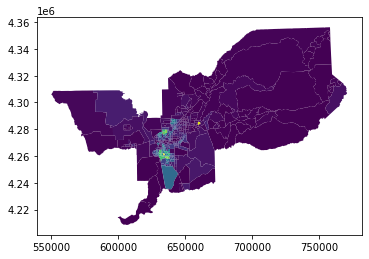

In [21]:
# original data
sacramento.plot('BLACK')

## Deprecation

In [22]:
from segregation.aspatial import  GiniSeg

In [23]:
GiniSeg(sacramento, group_pop_var='BLACK', 
                     total_pop_var='TOT_POP')

<ipython-input-23-212071080814>:1: DeprecatedWarning: GiniSeg is deprecated as of 2.0 and will be removed in 2.2. singlegroup.GiniSeg or multigroup.GiniSeg
  GiniSeg(sacramento, group_pop_var='BLACK',


In [24]:
dep_res = GiniSeg(sacramento, group_pop_var='BLACK', 
                     total_pop_var='TOT_POP')

<ipython-input-24-d66bdb35a872>:1: DeprecatedWarning: GiniSeg is deprecated as of 2.0 and will be removed in 2.2. singlegroup.GiniSeg or multigroup.GiniSeg
  dep_res = GiniSeg(sacramento, group_pop_var='BLACK',


In [25]:
dep_res.statistic == aspatial_gini.statistic

array([ True])